In [6]:
import numpy as np
import scipy
import mlpp.pp.hawkes as hk
from mlpp.base.utils import TimeFunction
import matplotlib.pyplot as plt
%matplotlib inline

## Read arguments

In [2]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-k",help="Choose a kernel among: 'exp', 'rectangular' or 'powerlaw'.",type=str,choices=['exp','rectangular','powerlaw'])
parser.add_argument("-d",help="Choose the dimension of the process: 10 or 100.",type=int,choices=[10,100])
parser.add_argument("-s",help="Simulate either symmetric (1) or nonsymmetric (0).",type=int,choices=[0,1])
parser.add_argument("-t",help="log_10 of the length of the simulation ie '3' gives T=1000",type=int,choices=[3,4,5,6,7,8])
args = parser.parse_args()

usage: __main__.py [-h] [-k {exp,rectangular,powerlaw}] [-d {10,100}]
                   [-s {0,1}] [-t {3,4,5,6,7,8}]
__main__.py: error: unrecognized arguments: -f /Users/massil/.ipython/profile_default/security/kernel-aad0bea3-c0d4-4c60-b289-bbcfe869f7a8.json --profile-dir /Users/massil/.ipython/profile_default


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.


## Dataset to simulate 

In [3]:
if args.k is None:
    kernel = 'exp'
else:
    kernel = args.k
    
if args.d is None:
    d = 10
else:
    d = args.d
    
if args.s is None:
    symmetric = True
else:
    symmetric = args.s
    
if args.t is None:
    T = 1e5
else:
    T = 10**args.t

NameError: name 'args' is not defined

In [4]:
if symmetric:
    mode = 'd' + str(d) + '_sym'
else:
    mode = 'd' + str(d) + '_nonsym'

NameError: name 'symmetric' is not defined

## Major key for exp kernel: 
### Since hMax=40 encodes the support, we ensure \beta is not too small for estimation
Criterion on exp kernel gives us $\beta_{\min}$ such that $$\exp(-\mbox{hMax} \times \beta_\min) = 10^{-4}$$

In [2]:
hMax = 40
from math import log
beta_min = log(1000) / hMax
print("We have")
print("    beta_min = ",beta_min)

We have
    beta_min =  0.17269388197455343


In [3]:
mode = 'd10_sym'

In [7]:
if mode == 'd10_sym':
    d = 10
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Delta = np.zeros((d,d))
    Alpha[:d/2,:d/2] += 1.
    Alpha[d/2:,d/2:] += 1.
    Beta[:d/2,:d/2] += 1000*beta_min
    Beta[d/2:,d/2:] += 10*beta_min
    # add noise
    #Alpha += 0.01
    Alpha[6:8,:3] += 3.
    Beta[6:8,:3] += 100*beta_min
    Alpha = .5*(Alpha+Alpha.T)
    Delta = .5*Alpha
    Beta = .5*(Beta + Beta.T)
    Alpha /= 12
    
elif mode == 'd10_nonsym':
    d = 10
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Delta = np.zeros((d,d))
    for i in range(5):
        for j in range(5):
            if i <= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 1000*beta_min
    for i in range(5,10):
        for j in range(5,10):
            if i >= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 10*beta_min
    Delta = .5*Alpha
    Alpha /= 6
    
elif mode == 'd100_sym':
    d = 100
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Delta = np.zeros((d,d))
    Alpha[:d/2,:d/2] += 1.
    Alpha[d/2:,d/2:] += 1.
    Beta[:d/2,:d/2] += 1000*beta_min
    Beta[d/2:,d/2:] += 10*beta_min
    #add noise
    #Alpha += 0.01
    Alpha[60:70,10:20] += 3.
    Alpha = .5*(Alpha+Alpha.T)
    Beta[60:70,10:20] += 100*beta_min
    Beta = .5*(Beta + Beta.T)
    Delta = .5*Alpha
    Alpha /= 120
    
elif mode == 'd100_nonsym':
    d = 100
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Delta = np.zeros((d,d))
    for i in range(40):
        for j in range(40):
            if i <= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 10*beta_min
    for i in range(41,60):
        for j in range(41,60):
            Alpha[i][j] = 1.
            Beta[i][j] = (100+900*np.random.rand())*100.*beta_min
    for i in range(61,100):
        for j in range(61,100):
            if i >= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 100.*beta_min
    Delta = .5*Alpha
    Alpha /= 30

In [10]:
assert (Beta[Beta > 0] > 1).all(), "Beta should be greater than 1 to ensure \phi \in L_1 for power law kernels."

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


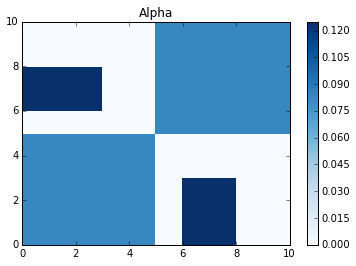

In [15]:
plt.pcolor(Alpha,cmap=plt.cm.Blues)
plt.title("Alpha")
plt.colorbar()
plt.show()
plt.close()

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


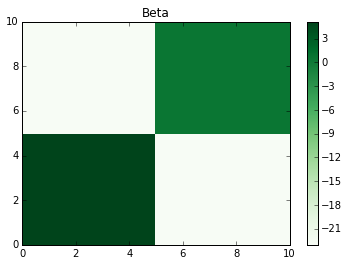

In [13]:
eps = 1e-10
plt.pcolor(np.log(eps+Beta),cmap=plt.cm.Greens)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()

## Simulation of the process

### Design rectangular kernel

In [ ]:
Phi_norm = np.zeros_like(Alpha)
if kernel == 'exp':
    kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha, Beta)]
    Phi_norm = Alpha.copy()
elif kernel == 'powerlaw':
    kernels = [[hk.HawkesKernelPowerLaw(a, d, b, 2000) for (a, b, d) in zip(a_list, b_list, d_list)] for (a_list, b_list, d_list) in zip(Alpha, Beta, Delta)]
    Phi_norm = 1./(Beta-1.)*Alpha/(Delta**(Beta-1))
elif kernel == 'rectangular':
    def kernel_rect(a, d):
        T = np.array([0, min(a,d), max(a,d)], dtype=float)
        Y = np.array([0, .2,0], dtype=float)
        tf = TimeFunction([T, Y], inter_mode=TimeFunction.InterConstRight)
        return hk.HawkesKernelTimeFunc(tf)
    kernels = [[kernel_rect(a, d) for (a, d) in zip(a_list, d_list)] for (a_list, d_list) in zip(Alpha, Delta)]
    Phi_norm = .2*abs(Alpha-Delta)

### Check if $||\Phi|| = Alpha_{true}$, can generate a stable Hawkes process

In [ ]:
_, s, _ = np.linalg.svd(Phi_norm)
print(s.max())
assert s.max() < 1, "Alpha cannot generate a stable Hawkes process"

In [35]:
h = hk.Hawkes(kernels=kernels, mus=list(mu))
h.simulate(T)

## Use the class Cumulants

In [43]:
from utils.cumulants import Cumulants
N = h.get_full_process()
cumul = Cumulants(N,hMax=16)
# compute everything
cumul.compute_all()
from scipy.linalg import inv
R_true = inv(np.eye(d)-Phi_norm)
cumul.set_R_true(R_true)
cumul.set_C_th()
cumul.set_K_th()
cumul.compute_B()
cumul.set_K_part()
cumul.set_K_part_th()

In [44]:
from utils.metrics import rel_err
print(rel_err(cumul.C_th,cumul.C))
print(rel_err(cumul.K_th,cumul.K))
print(rel_err(cumul.K_part_th,cumul.K_part))

0.00168842717643
53.2866145284
49.2822287248


In [37]:
with_Beta = True
without_N = True

if with_Beta and without_N:
    cumul.N = None
    data = (cumul,Beta)
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_with_Beta_without_N.pkl.gz','wb')
    pickle.dump(data, f, protocol=2)
    f.close()
    cumul.N = h.get_full_process()
    
elif with_Beta and not without_N:
    data = (cumul,Beta)
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_with_Beta.pkl.gz','wb')
    pickle.dump(data, f, protocol=2)
    f.close()
    
elif not with_Beta and without_N:
    cumul.N = None
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_without_N.pkl.gz','wb')
    pickle.dump(cumul, f, protocol=2)
    f.close()
    cumul.N = h.get_full_process()

elif not with_Beta and not without_N:
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '.pkl.gz','wb')
    pickle.dump(cumul, f, protocol=2)
    f.close()